In [80]:
import yfinance as yf
import numpy as np
import pandas as pd

#download the data
df = yf.download('SPY',interval='5m',period='60d')

#flatten multi level columns(eg:('Close','SPY')->'Close')
df.columns = [col[0] if isinstance(col,tuple) else col for col in df.columns]

#calculate vwap
df['cum-vol-price'] = (df['Volume']*df['Close']).cumsum()
df['cum-vol'] = df['Volume'].cumsum()
df['VWAP'] = df['cum-vol-price']/df['cum-vol']

df['delta'] = np.where(
    df['Close'] > df['Open'], df['Volume'], 
    np.where(df['Close'] < df['Open'], -df['Volume'], 0)
)

df['CVD'] = df['delta'].cumsum()

#generate signals
df['signal'] = np.where(
    (df['Close'] > df['VWAP']) &
    (df['CVD'] > df['CVD'].rolling(20).mean()), 1, 0
)


#strategy backtest
df['Returns'] = df['Close'].pct_change()
df['Strategy_Return'] = df['signal'].shift(1)*df['Returns']

#summerize performance

strat_return = (df['Strategy_Return'] + 1).prod() - 1
bh_return = (df['Returns'] + 1).prod() - 1

print(f"Strategy Return: {strat_return:.2%}")
print(f"Buy & Hold Return: {bh_return:.2%}")




C:\Users\User\AppData\Local\Temp\ipykernel_9356\579967108.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('SPY',interval='5m',period='60d')
[*********************100%***********************]  1 of 1 completed

Strategy Return: 3.50%
Buy & Hold Return: 5.38%


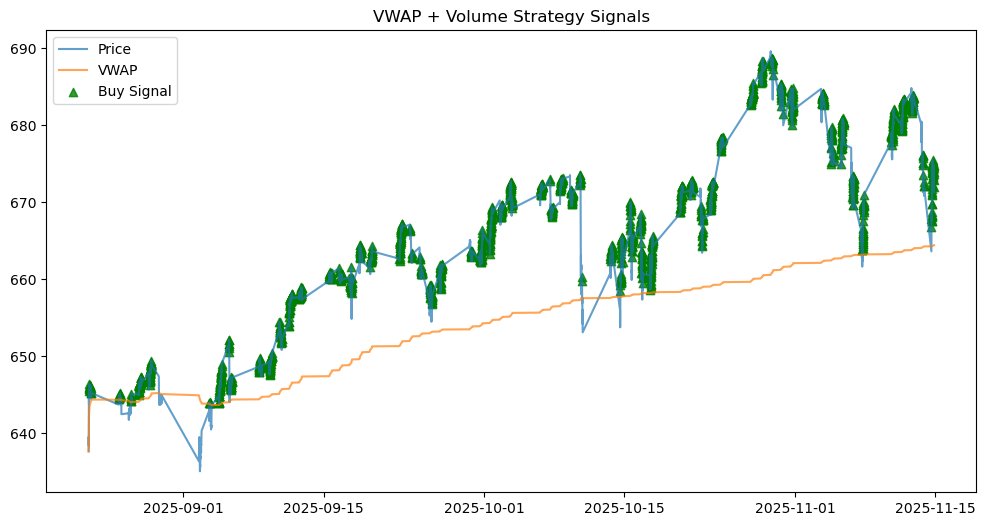

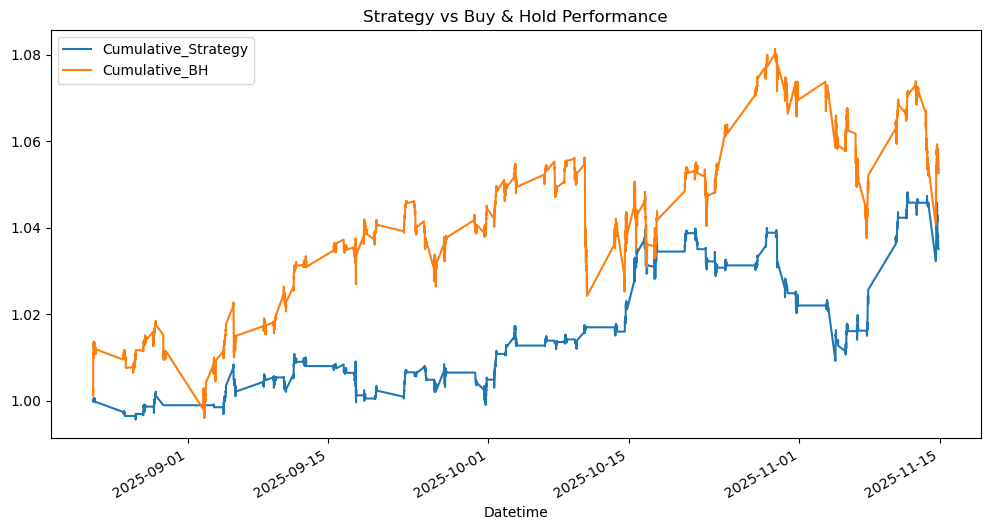

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Price', alpha=0.7)
plt.plot(df.index, df['VWAP'], label='VWAP', alpha=0.7)
plt.scatter(df.index[df['signal'] == 1], df['Close'][df['signal'] == 1],
            color='green', label='Buy Signal', marker='^', alpha=0.8)
plt.title("VWAP + Volume Strategy Signals")
plt.legend()
plt.show()

# Equity curve
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()
df['Cumulative_BH'] = (1 + df['Returns']).cumprod()

df[['Cumulative_Strategy', 'Cumulative_BH']].plot(figsize=(12,6))
plt.title("Strategy vs Buy & Hold Performance")
plt.show()
